<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/question-answering/Question_Answering_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle
import numpy as np
#%tensorflow_version 2.x

In [0]:
try:
  print('Uploading in progress...')
  with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)
  with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)
except Exception as ex:
  print(ex)

Uploading in progress...


In [0]:
train_data.__len__()

10000

In [0]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [0]:
all_data = test_data + train_data

In [0]:
len(all_data)

11000

In [0]:
vocab = set()

for story, question, answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [0]:
vocab.add('yes')
vocab.add('no')

In [0]:
vocab_len = len(vocab) + 1

In [0]:
max_story_len = max([len(data[0]) for data in all_data])

In [0]:
max_question_len = max([len(data[1]) for data in all_data])

In [0]:
max_question_len

6

In [0]:
max_story_len

156

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer 

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [0]:
tokenizer.word_index

{'.': 22,
 '?': 28,
 'apple': 31,
 'back': 21,
 'bathroom': 13,
 'bedroom': 33,
 'daniel': 15,
 'discarded': 32,
 'down': 36,
 'dropped': 20,
 'football': 8,
 'garden': 27,
 'got': 16,
 'grabbed': 34,
 'hallway': 26,
 'in': 37,
 'is': 14,
 'john': 4,
 'journeyed': 10,
 'kitchen': 1,
 'left': 7,
 'mary': 18,
 'milk': 25,
 'moved': 11,
 'no': 2,
 'office': 24,
 'picked': 19,
 'put': 17,
 'sandra': 6,
 'the': 12,
 'there': 23,
 'to': 9,
 'took': 5,
 'travelled': 3,
 'up': 35,
 'went': 30,
 'yes': 29}

In [0]:
train_story_text = []
train_question_text = []
train_answers = []

In [0]:
for story, question, answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answers.append(answer)

In [0]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [0]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):
  # stories
  X = []
  # questions
  Xq = []
  # Y CORRECT ANSWER
  Y = []

  for story, query, answer in data:
    # for each story
    # [23,14,...]
    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in query]

    y = np.zeros(len(word_index)+1)
    y[word_index[answer]] = 1
    X.append(x)
    Xq.append(xq)
    Y.append(y)
  return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len), np.array(Y))

In [0]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [0]:
print(tokenizer.word_index['yes'])
print(tokenizer.word_index['no'])

29
2


In [0]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Dropout, Permute, concatenate, LSTM, add, dot, BatchNormalization

In [0]:
input_sequence = Input(shape=(max_story_len,))
question = Input(shape=(max_question_len,))

In [0]:
vocab_size = len(vocab) + 1

In [0]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [0]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [0]:
# INPUT ENCODER C
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [0]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [0]:
match = dot([input_encoded_m,question_encoded], axes=(2,2))
match = Activation('softmax')(match)

response = add([match, input_encoded_c])
response = Permute((2,1))(response)

answer = concatenate([response, question_encoded])

In [0]:
answer = LSTM(128,return_sequences=True)(answer)
answer = Dropout(0.5)(answer)
answer = LSTM(64)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

model = Model([input_sequence,question],answer)

In [0]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       multiple             2432        input_5[0][0]                    
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 6, 64)        2432        input_6[0][0]                    
____________________________________________________________________________________________

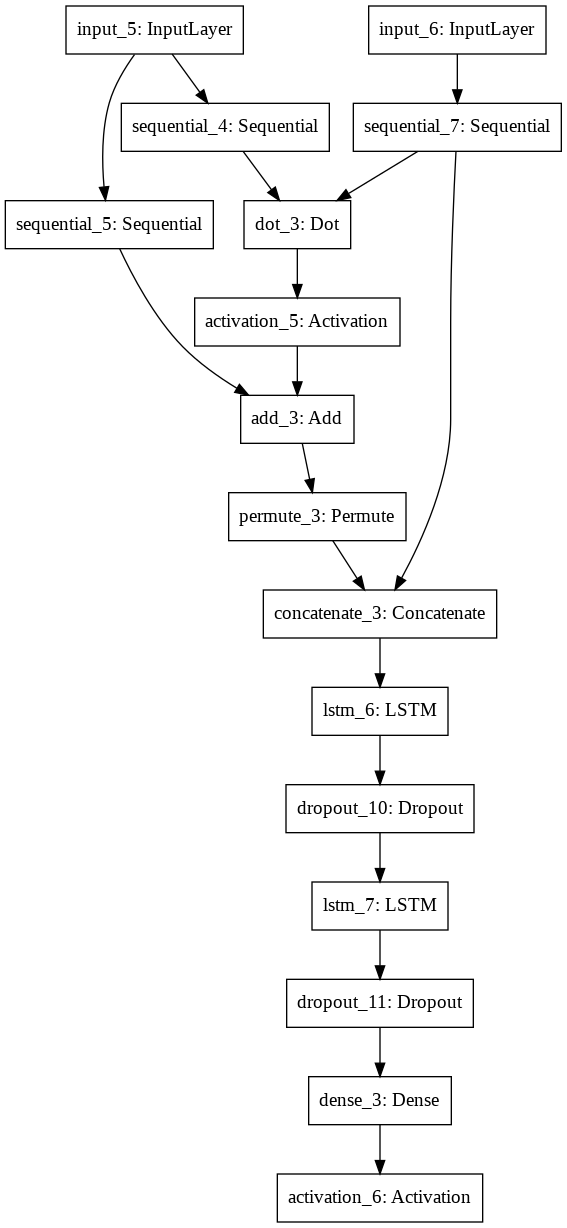

In [0]:
import keras
keras.utils.plot_model(model)

In [0]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=200,validation_data=([inputs_test,queries_test], answers_test),callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)])

Train on 10000 samples, validate on 1000 samples
Epoch 1/200
10000/10000 [==============================] - 7s 725us/step - loss: 0.6949 - acc: 0.4974 - val_loss: 0.6945 - val_acc: 0.5030
Epoch 2/200
10000/10000 [==============================] - 7s 723us/step - loss: 0.6945 - acc: 0.5006 - val_loss: 0.6933 - val_acc: 0.4970
Epoch 3/200
10000/10000 [==============================] - 7s 722us/step - loss: 0.6951 - acc: 0.4935 - val_loss: 0.6945 - val_acc: 0.4970
Epoch 4/200
10000/10000 [==============================] - 7s 717us/step - loss: 0.6946 - acc: 0.4922 - val_loss: 0.6946 - val_acc: 0.4970
Epoch 5/200
10000/10000 [==============================] - 7s 722us/step - loss: 0.6945 - acc: 0.5006 - val_loss: 0.6937 - val_acc: 0.4970
Epoch 6/200
10000/10000 [==============================] - 7s 722us/step - loss: 0.6950 - acc: 0.4977 - val_loss: 0.6931 - val_acc: 0.5030
Epoch 7/200
10000/10000 [==============================] - 7s 741us/step - loss: 0.6946 - acc: 0.5044 - val_loss: 0.6

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


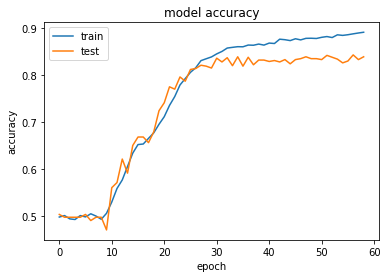

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [0]:
model.save('chatbot.h5')

In [0]:
pred_results = model.predict(([inputs_test,queries_test]))

In [0]:
pred_results[0]

array([1.2570566e-18, 9.3914240e-19, 9.9844801e-01, 1.1034019e-18,
       7.0218406e-19, 6.4692669e-19, 6.1237633e-19, 1.2212519e-18,
       1.0305061e-18, 7.0288892e-19, 9.8016622e-19, 6.1915777e-19,
       1.0466623e-18, 9.1403375e-19, 6.1810291e-19, 6.8157780e-19,
       6.5062413e-19, 5.4148510e-19, 5.6316922e-19, 7.7777777e-19,
       6.5122999e-19, 1.0354316e-18, 6.6014436e-19, 1.0125075e-18,
       7.4919242e-19, 9.5040478e-19, 9.1094961e-19, 9.1702670e-19,
       8.0014406e-19, 1.5519150e-03, 1.1336907e-18, 6.3752904e-19,
       7.8216348e-19, 6.2916490e-19, 8.9739811e-19, 1.0061737e-18,
       9.7870159e-19, 7.7939951e-19], dtype=float32)

In [0]:
val_max = np.argmax(pred_results[0])

In [0]:
for key,val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [0]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

my_question = "Is the football in the garden ?"
my_question.split()

mydata = [(my_story.split(),my_question.split(),'yes')]

my_story, my_ques, my_ans = vectorize_stories(mydata)

pred_result = model.predict(([my_story, my_ques]))
val_max = np.argmax(pred_result[0])

In [0]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key
print(k)

yes
